In [95]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import matplotlib.pyplot as plt

In [96]:
# set up the model and data
np.random.seed(5673424)
size = 200
true_intercept = 1
true_slope = 5
sigma = 1
x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + np.random.normal(0, sigma ** 2, size)
s= sigma
#s = np.identity(y.shape[0])
#np.fill_diagonal(s, sigma ** 2)

# reduced dataset
#x_coarse_0 = x[::4]
#y_coarse_0 = y[::4]
x_coarse_1 = x[::2]
y_coarse_1 = y[::2]
#s_0 = np.identity(y_coarse_0.shape[0])
#np.fill_diagonal(s_0, sigma ** 2)
#s_1 = np.identity(y_coarse_1.shape[0])
#np.fill_diagonal(s_1, sigma ** 2)

# MCMC parameters
ndraws = 1000
ntune = 500
nsub = 5
nchains = 2
seed = 98765

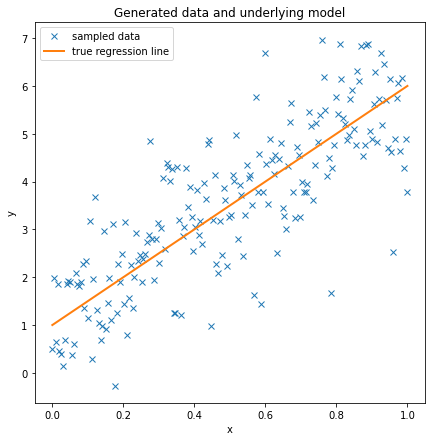

In [97]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [98]:
class Likelihood(tt.Op):
    if theano.config.floatX == "float32":
        itypes = [tt.fvector]
        otypes = [tt.fscalar]
    else:
        itypes = [tt.dvector]
        otypes = [tt.dscalar]

    def __init__(self, x, y, pymc3_model):
        self.x = x
        self.y = y
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        temp = intercept + x_coeff * self.x
        self.pymc3_model.Q.set_value(x_coeff)
        outputs[0][0] = np.array(- (0.5 / s ** 2) * np.sum((temp - self.y) ** 2))

In [99]:
'''
class ForwardModel(tt.Op):
    if theano.config.floatX == "float32":
        itypes = [tt.fvector]
        otypes = [tt.fvector]
    else:
        itypes = [tt.dvector]
        otypes = [tt.dvector]

    def __init__(self, x, pymc3_model):
        self.x = x
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        temp = intercept + x_coeff * self.x
        self.pymc3_model.Q.set_value(x_coeff)
        outputs[0][0] = temp
'''

'\nclass ForwardModel(tt.Op):\n    if theano.config.floatX == "float32":\n        itypes = [tt.fvector]\n        otypes = [tt.fvector]\n    else:\n        itypes = [tt.dvector]\n        otypes = [tt.dvector]\n\n    def __init__(self, x, pymc3_model):\n        self.x = x\n        self.pymc3_model = pymc3_model\n\n    def perform(self, node, inputs, outputs):\n        intercept = inputs[0][0]\n        x_coeff = inputs[0][1]\n\n        temp = intercept + x_coeff * self.x\n        self.pymc3_model.Q.set_value(x_coeff)\n        outputs[0][0] = temp\n'

In [100]:
coarse_models = []
mout = []
'''
with pm.Model() as coarse_model_0:            
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s_0)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x_coarse_0, coarse_model_0))
        
    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[0](theta),
    #                      cov=Sigma_e, observed=y_coarse_0)
    
    mout.append(Likelihood(x_coarse_0, y_coarse_0, coarse_model_0))
    pm.Potential('likelihood', mout[0](theta))

    coarse_models.append(coarse_model_0)
'''
with pm.Model() as coarse_model_1:    
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s_1)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x_coarse_1, coarse_model_1))    

    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[1](theta),
    #                      cov=Sigma_e, observed=y_coarse_1)
    
    mout.append(Likelihood(x_coarse_1, y_coarse_1, coarse_model_1))
    pm.Potential('likelihood', mout[0](theta))

    coarse_models.append(coarse_model_1)



In [101]:
with pm.Model() as model:    
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x, model))

    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[2](theta),
    #                      cov=Sigma_e, observed=y)
    
    mout.append(Likelihood(x, y, model))
    pm.Potential('likelihood', mout[1](theta))

    step = pm.MLDA(coarse_models=coarse_models,
                   subsampling_rates=nsub,
                variance_reduction=True,
                store_Q_fine=True)
    
    step2 = pm.DEMetropolisZ()

    trace = pm.sample(draws=ndraws, step=step,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=seed)
    
    trace2 = pm.sample(draws=ndraws, step=step2,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=seed)

/Users/gmingas/projects/pymc3-vr/pymc3/step_methods/metropolis.py:1096: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


In [102]:
pm.stats.summary(trace)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.217,0.133,0.984,1.478,0.006,0.005,424.0,416.0,418.0,558.0,1.01
x,4.623,0.226,4.182,5.046,0.012,0.008,371.0,371.0,363.0,694.0,1.01


In [103]:
pm.stats.summary(trace2)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.198,0.130,0.969,1.416,0.008,0.006,271.0,271.0,275.0,459.0,1.00
x,4.644,0.219,4.247,5.055,0.013,0.009,281.0,280.0,280.0,281.0,1.01


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

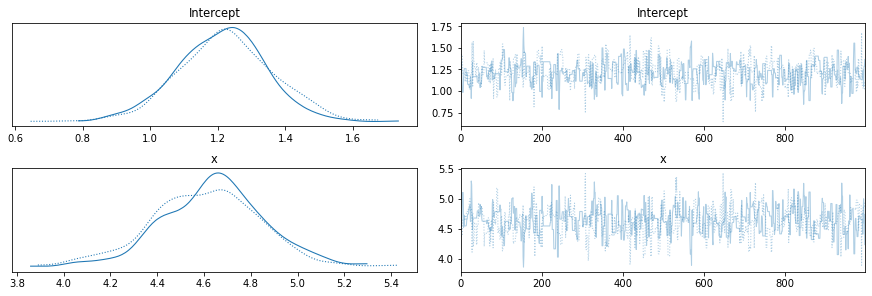

In [104]:
pm.plots.traceplot(trace)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

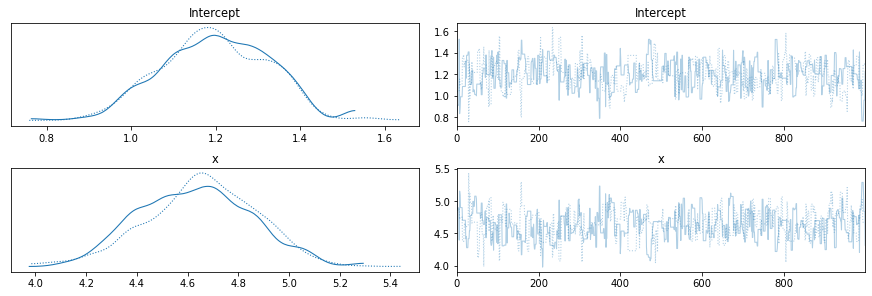

In [105]:
pm.plots.traceplot(trace2)

In [106]:
Q_1 = trace.get_sampler_stats("Q_1").reshape((nchains, ndraws))
Q_0 = np.concatenate(trace.get_sampler_stats("Q_0")).reshape((nchains, ndraws * nsub))
Q_1_0 = np.concatenate(trace.get_sampler_stats("Q_1_0")).reshape((nchains, ndraws ))
#Q_2_1 = np.concatenate(trace.get_sampler_stats("Q_2_1")).reshape((nchains, ndraws))
Q_mean_standard = Q_1.mean(axis=1).mean()
Q_mean_vr = (Q_0.mean(axis=1) + Q_1_0.mean(axis=1)).mean()

print(f"Q_0 mean = {Q_0.mean(axis=1)}")
print(f"Q_1 mean = {Q_1.mean(axis=1)}")
print(f"Q_1_0 mean = {Q_1_0.mean(axis=1)}")
#print(f"Q_2_1 mean = {Q_2_1.mean(axis=1)}")
print(f"Standard method:    Mean: {Q_mean_standard}")
print(f"VR method:    Mean: {Q_mean_vr}")



Q_0 mean = [4.83376309 4.80025937]
Q_1 mean = [4.6423938108136715 4.603687213916795]
Q_1_0 mean = [-0.19550644 -0.20256373]
Standard method:    Mean: 4.623040512365233
VR method:    Mean: 4.61797614709787


In [107]:
Q_1.shape

(2, 1000)

In [108]:
Q_1_0[1].var()

0.11281168354222322

In [109]:
Q_0.mean(), Q_1.mean(), Q_1_0.mean()

(4.817011231964652, 4.623040512365226, -0.1990350848667824)

In [110]:
Q_1.var(axis=1), Q_0.var(axis=1), Q_1_0.var(axis=1)

(array([0.047286258393685845, 0.05401165869562893], dtype=object),
 array([0.11256685, 0.12145518]),
 array([0.1118097 , 0.11281168]))

(array([ 1.,  0.,  0.,  1.,  5.,  1.,  5.,  2.,  0.,  0.,  0.,  4.,  1.,
         6.,  3.,  1.,  5.,  2.,  8.,  5.,  4.,  0., 11., 12.,  7.,  4.,
         8.,  2.,  3., 23., 10.,  4.,  7.,  7., 10., 22., 13.,  8., 23.,
        21., 17., 23., 12., 29., 17.,  8., 28., 18., 26., 40., 49., 35.,
        33., 30., 17., 25., 38., 23., 42., 57., 29., 33., 41., 47., 42.,
        54., 20., 51., 61., 64., 32., 76., 48., 34., 84., 56., 69., 68.,
        71., 83., 55., 65., 61., 53., 46., 84., 89., 69., 81., 81., 65.,
        73., 73., 56., 62., 54., 80., 38., 54., 49., 56., 91., 54., 69.,
        70., 66., 80., 73., 60., 56., 31., 45., 47., 46., 43., 65., 41.,
        68., 27., 45., 33., 28., 42., 10., 43., 35., 18., 23., 17., 15.,
        13., 19., 21., 41., 14., 37., 30., 30., 28.,  9., 13.,  6., 18.,
        14., 10.,  6.,  7., 11.,  5., 20., 13.,  7.,  7.,  4.,  0.,  0.,
         5.,  7.,  4.,  5.,  8.,  0.,  0.,  7.,  2.,  2.,  9.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.

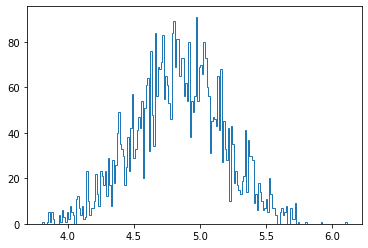

In [111]:
plt.hist(Q_0[0], bins=200, histtype='step')

In [112]:
Q_1


array([[array(4.53321834), array(4.53321834), array(4.53321834), ...,
        array(4.73306381), array(4.23280601), array(4.23280601)],
       [array(4.37556823), array(4.37556823), array(4.37556823), ...,
        array(4.84846595), array(4.95752673), array(4.95752673)]],
      dtype=object)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,
          2.,   1.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,   1.,   2.,
          1.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   2.,   1.,
          0.,   0.,   0.,   1.,   2.,   3.,   1.,   0.,   1.,   3.,   4.,
          3.,   1.,   3.,   0.,   3., 

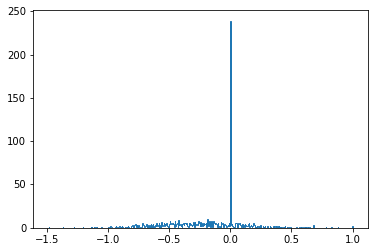

In [113]:
plt.hist(Q_1_0[0,:], bins=500, histtype='step')

In [114]:
import arviz
ess_Q1 = arviz.ess(np.array(Q_1,np.float64))
ess_Q0 = arviz.ess(np.array(Q_0,np.float64))
ess_Q_1_0 = arviz.ess(np.array(Q_1_0,np.float64))
#ess_Q_2_1 = arviz.ess(np.array(Q_2_1,np.float64))

In [115]:
ess_Q1, ess_Q0, ess_Q_1_0

(362.5000996027004, 1369.6297705415234, 1570.7137647000648)

In [116]:
Q_1.var()/ess_Q1

0.0001407544680992198

In [117]:
Q_0.var()/ess_Q0

8.563747773739591e-05

In [118]:
Q_1_0.var()/ess_Q_1_0

7.151089340828366e-05

In [119]:
Q_2_1.var()/ess_Q_2_1

NameError: name 'Q_2_1' is not defined